# Stage 4: Alignment with Sustainable Development Goals

- **Authors:** Arian Contessotto, Tim Giger, Levin Reichmuth
- **Date of Submission:** 1st June 2023

In this notebook, the technique of sentence embedding is applied to analyse the SDG alignment of German DAX companies, as reflected by communications by and about these companies. Furthermore, differences between internal and external perception are pointed not only for each company but also at sector and industry level.

In [1]:
# Set connection to google drive
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Required package installation
!pip install sentence_transformers
!pip install torch
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import packages
import pandas as pd
import numpy as np
import sentence_transformers
import torch
import plotly.graph_objects as go
import plotly.io as pio
import kaleido
from IPython.display import Image

##1. Load Data

In this stage, the data is loaded. The two datasets are the ESG documents after completion of stage 3 and the SDG descriptions. Afterwards, texts are formed by concatenating selected columns. Finally, the unique companies, sectors and industries are assigned to a list. The text forming and company, sector and industry storing are necessary preprocessing steps for sentence embedding. Note that in contrary to the provided notebook by the task owner, SwissText, we decided to use the cleaned content instead of the raw content. Thus the column 'content' has been replaced by 'cleaned_content' as input for sentence embedding. Since text cleaning is very important in NLP, we regard this replacement as a sensible adjustment.

In [4]:
# Define file name
esg_file = '/content/drive/MyDrive/Colab_Notebooks/CLT_Project_HSLU_Stage3/stage2_output.csv'

# Define function to load and merge data
def load_esg_data(file):

     # Load the data
     df = pd.read_csv(file, delimiter = '|')

     # Drop unnecessary columns
     df.drop(['sentence_tokens', 'market_cap_in_usd_b', 'year_month', 'month', 'symbol', 'domain', 'cnt_word', 'year',
              'st1_sentiment_continuous', 'st2_sentiment_llm_continuous', 'st2_sentiment_llm_categorical'], axis=1, inplace=True)

     # Drop Hanover R from dataframe because no external documents exist => interferes with figures
     df.drop(df.loc[df['company'] == 'Hannover R'].index, inplace=True)

     # Reset the index
     df.reset_index(drop=True, inplace=True)

     # Apply eval function to columns esg_topics
     df['esg_topics'] = df['esg_topics'].apply(eval)

     return df

# Load and merge the data
esg_documents_df = load_esg_data(esg_file)

# Print shape and diyplay header
print(esg_documents_df.shape)
esg_documents_df.head()

(11070, 9)


,company,datatype,title,date,cleaned_content,esg_topics,internal,sector,industry
0,Beiersdorf,sustainability_report,BeiersdorfAG Sustainability Report 2021,2021-03-31,brand strategy sustainability agenda care beyo...,"[CleanWater, GHGEmission, ProductLiability, Va...",1,Consumer Staples,Household & Personal Products
1,Deutsche Telekom,sustainability_report,DeutscheTelekomAG Sustainability Report 2021,2021-03-31,management fact deutsche telekoms cr report th...,"[DataSecurity, Iso50001, GlobalWarming, Produc...",1,Communication Services,Telecom Services
2,Vonovia,sustainability_report,VonoviaSE Sustainability Report 2021,2021-03-31,sustainable future se sustainability report de...,"[Whistleblowing, DataSecurity, Vaccine, GHGEmi...",1,Real Estate,Real Estate Services
3,Merck,sustainability_report,MerckKGaA Sustainability Report 2021,2021-03-31,management employee profile attractive employe...,"[DataSecurity, DataMisuse, DrugResistance, Iso...",1,Healthcare,Drug Manufacturers—Specialty & Generic
4,MTU,sustainability_report,MTUAeroEngines Sustainability Report 2020,2020-03-31,sustainability go far beyond climate action sa...,"[WorkLifeBalance, Corruption, AirQuality, Data...",1,Industrials,Aerospace & Defense


In [5]:
# Form esg_texts by concatenating title and cleaned content
esg_texts = esg_documents_df.apply(lambda row: " ".join([str(row["title"]), str(row["cleaned_content"])]), axis=1)
esg_texts[0][:100]

'BeiersdorfAG Sustainability Report 2021 brand strategy sustainability agenda care beyond skin partne'

In [6]:
# Load SDG descriptions
sdg_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CLT_Project_HSLU_Stage3/sdg_descriptions_with_targetsText.csv")

# Display header
sdg_df.head()

,id,name,description,targets,targets_json_array,progress
0,1,No Poverty,End poverty in all its forms everywhere,"['1.1', 'By 2030, eradicate extreme poverty fo...","[{""target"":""1.1"",""description"":""By 2030, eradi...",['The impact of the COVID-19 pandemic reversed...
1,2,Zero Hunger,"End hunger, achieve food security and improved...","['2.1', 'By 2030, end hunger and ensure access...","[{""target"":""2.1"",""description"":""By 2030, end h...","['Between 2014 and the onset of the pandemic, ..."
2,3,Good Health and Well-being,Ensure healthy lives and promote well-being fo...,"['3.1', 'By 2030, reduce the global maternal m...","[{""target"":""3.1"",""description"":""By 2030, reduc...","['By April 2022, the coronavirus causing COVID..."
3,4,Quality Education,Ensure inclusive and equitable quality educati...,"['4.1', 'By 2030, ensure that all girls and bo...","[{""target"":""4.1"",""description"":""By 2030, ensur...",['The COVID-19 outbreak has caused a global ed...
4,5,Gender Equality,Achieve gender equality and empower all women ...,"['5.1', 'End all forms of discrimination again...","[{""target"":""5.1"",""description"":""End all forms ...","[""The world is not on track to achieve gender ..."


In [7]:
# Form sdg_texts by concatenating name and description, targets and progress
sdg_texts = sdg_df.apply(lambda row: " ".join([row["name"], row["description"], row["targets"], row["progress"]]), axis=1)
sdg_texts[0][:100]

"No Poverty End poverty in all its forms everywhere ['1.1', 'By 2030, eradicate extreme poverty for a"

In [8]:
# Store unique companies in list
companies = sorted(esg_documents_df.company.unique())
print('First 5 companies:', companies[:5])

# Store unique sectors in list
sectors = sorted(esg_documents_df.sector.unique())
print('First 5 sectors:', sectors[:5])

# Store unique industries in list
industries = sorted(esg_documents_df.industry.unique())
print('First 5 industries:', industries[:5])

First 5 companies: ['Adidas', 'Airbus', 'AkzoNobelNV', 'Allianz', 'BMW']
First 5 sectors: ['Basic Materials', 'Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Financials']
First 5 industries: ['Aerospace & Defense', 'Auto Manufacturers', 'Auto Parts', 'Banks', 'Building Materials']


##2. Build Embeddings

In [9]:
# Make sure to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Load the retriever model from huggingface model hub
retriever = sentence_transformers.SentenceTransformer("flax-sentence-embeddings/all_datasets_v3_mpnet-base", device=device)
retriever

cuda


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [10]:
# Perform sentence embedding
company_text_embeddings = retriever.encode(esg_texts)
sdg_embeddings = retriever.encode(sdg_texts)

# Clear cache after sentence embedding
torch.cuda.empty_cache()

##3. SDG Alignment of DAX Companies

We model SDG alignment as the similarity between the company-related texts and the SDG descriptions. In this section, we first define the similarity function using standard cosine similarity. We then perform some alignment analysis including visualizations and interpretations. All analysis are executed on a company, sector and industry level.

In [11]:
# Function to compute similarity
def cosine_similarity(embedding1, embedding2):
    sim = np.dot(embedding1, embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))
    return sim

### 3.1 Most Relevant SDGs for DAX Companies - Overview

Let's first consider the overall relevance of the 17 SDGs for all DAX companies taken together. We first compute an embedding that averages over all company texts. Then, we compare this embedding with the embeddings of the SDGs.

In [12]:
# Calculate average over all company texts
all_companies_embedding = np.mean(company_text_embeddings, axis=0)

# Call function to calcualate similarities
sdg_relevance_scores = [cosine_similarity(all_companies_embedding, sdg_embedding) for sdg_embedding in sdg_embeddings]
sdg_relevance_series = pd.Series(sdg_relevance_scores, index=sdg_df["name"])
sdg_relevance_series.sort_values(inplace=True)

# Display header
sdg_relevance_series.head(10)

name
Peace, Justice and Strong Institutions    0.222098
Gender Equality                           0.230646
Life On Land                              0.257306
Quality Education                         0.284981
Zero Hunger                               0.289747
Decent Work and Economic Growth           0.344861
Climate Action                            0.352121
Sustainable Cities and Communities        0.352338
No Poverty                                0.358131
Good Health and Well-being                0.359336
dtype: float32

In [13]:
# Display result
fig = go.Figure(data=[go.Bar(x=sdg_relevance_series, y=[sdg+" " for sdg in sdg_relevance_series.index], orientation='h')])
fig.update_layout(height=600, width=750, title="SDG Relevance for DAX Companies")
fig.update_xaxes(title="Relevance")
fig.show()

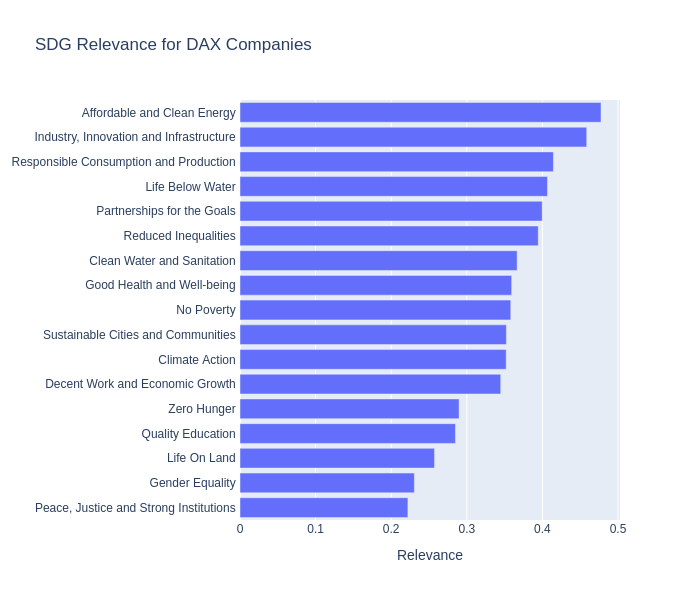

In [14]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig, format='png', height = 600, width = 700)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

The chart shows that 'Affordable and Clean Energy', with a value of 0.48, is the SDG with the greatest relevance for DAX Companies. The SDG 'Industry, Innovation and Infrastructure' is also highly relevant. The SDGs 'Peace, Justice and Strong Institutions' and 'Gender Equality' appear to be of less relevance. We consider these results to be consistent, as Germany is in the middle of the energy transition and renewable and affordable energy is therefore an important topic for many companies. In addition, Germany is a strong industrial nation, especially with the automotive industry, which is currently very busy with innovations in the field of electric cars. As Germany is a well-functioning constitutional state with reliable institutions in an international comparison, it is hardly surprising that this SDG has less relevance for DAX companies. In terms of gender equality, Germany also has an already progressive equality without extreme grievances.

### 3.2 Most Relevant SDGs for DAX Companies - Company Level

In this analysis, we focus on the most important SDGs at the company level. First, we take a closer look at a specific company defined by the variable COMPANY. We find the 'internal' and 'external' embeddings for this company, average them, and measure their similarity to each of the SDGs. We then aggregate and summarize the results for all companies by displaying heatmaps.

#### 3.2.1 Most Relevant SDGs for BMW

In [15]:
# Function to create SDG dataframe for analysis
def create_sdg_df(companies):

  # Initiate empty lists for dictionaries
  company_dicts = []

  # Loop over company list
  for company in companies:

    # Assign current company
    COMPANY = company

    # Get internal embeddings
    internal_company_indices = esg_documents_df[(esg_documents_df.company == COMPANY) & (esg_documents_df.internal == 1)].index
    internal_company_embedding = np.mean(company_text_embeddings[internal_company_indices], axis=0)

    # Get external embeddings
    external_company_indices = esg_documents_df[(esg_documents_df.company == COMPANY) & (esg_documents_df.internal == 0)].index
    external_company_embedding = np.mean(company_text_embeddings[external_company_indices], axis=0)

    # Get external embeddings
    overall_company_indices = esg_documents_df[(esg_documents_df.company == COMPANY)].index
    overall_company_embedding = np.mean(company_text_embeddings[overall_company_indices], axis=0)

    # Get scores
    company_sdg_relevance_scores = [[cosine_similarity(internal_company_embedding, sdg_embedding), 
                                    cosine_similarity(external_company_embedding, sdg_embedding),
                                    cosine_similarity(overall_company_embedding, sdg_embedding)] for sdg_embedding in sdg_embeddings]
    company_sdg_relevance_df = pd.DataFrame.from_records(company_sdg_relevance_scores, index=sdg_df["name"], columns=["internal", "external", "overall"])
    
    # Reset index
    company_sdg_relevance_df.reset_index(inplace=True)

    # Create list of dictionaries
    data = []
    for _, row in company_sdg_relevance_df.iterrows():
        name = row['name']
        internal = row['internal']
        external = row['external']
        overall = row['overall']
        mean_int_ext = (internal + external) / 2  # Calculate the mean
        diff = (internal - external)

        dictionary = {'name': name, 'internal': internal, 'external': external, 'overall': overall, 'mean_internal_external': mean_int_ext, 'diff': diff}
        data.append(dictionary)

    # Create company SDG dictionary
    company_sdg_relevance_dict = {'company': COMPANY,
                                  'sector': esg_documents_df[esg_documents_df['company']==COMPANY]['sector'].values[0],
                                  'industry': esg_documents_df[esg_documents_df['company']==COMPANY]['industry'].values[0],
                                  'sdg_relevance': data}

    # Append company SDG dictionary to list of dictionaries
    company_dicts.append(company_sdg_relevance_dict)

  # Call function and create dataframe
  df = pd.DataFrame(company_dicts)

  return df

# Call function and create dataframe
company_sdg_relevance_df = create_sdg_df(companies=companies)

# Safe dataframe to csv
company_sdg_relevance_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/CLT_Project_HSLU_Stage3/sentence_embedded_data.csv', index=False, sep='|')

# Display header
company_sdg_relevance_df.head()

,company,sector,industry,sdg_relevance
0,Adidas,Consumer Discretionary,Footwear & Accessories,"[{'name': 'No Poverty', 'internal': 0.26042130..."
1,Airbus,Industrials,Aerospace & Defense,"[{'name': 'No Poverty', 'internal': 0.28503850..."
2,AkzoNobelNV,Basic Materials,Chemicals,"[{'name': 'No Poverty', 'internal': 0.33059594..."
3,Allianz,Financials,Insurance—Diversified,"[{'name': 'No Poverty', 'internal': 0.40864089..."
4,BMW,Consumer Discretionary,Auto Manufacturers,"[{'name': 'No Poverty', 'internal': 0.28174707..."


In [16]:
# Function to display company SDG data
def company_sdg(company):

  # Inspect SDG data for one company
  data = company_sdg_relevance_df.loc[company_sdg_relevance_df['company'] == company]['sdg_relevance']
  data_list = data.reset_index(drop=True).to_dict()

  # Create company dataframe
  df = pd.DataFrame(data_list[0])
  df = df.sort_values(by='internal', ascending=False)

  return df

# Select company
company = 'BMW'

# Create company data
company_df = company_sdg(company=company)

In [17]:
# Display results
fig = go.Figure(data=[
    go.Bar(name='Internal', x=company_df["internal"], y=company_df['name'], orientation='h'),
    go.Bar(name='External', x=company_df["external"], y=company_df['name'], orientation='h')
])

fig.update_layout(barmode='group', height=800, width=1000, yaxis=dict(autorange="reversed"), title=f"SDG Relevance for {company}")
fig.update_xaxes(title="Relevance")
fig.show()

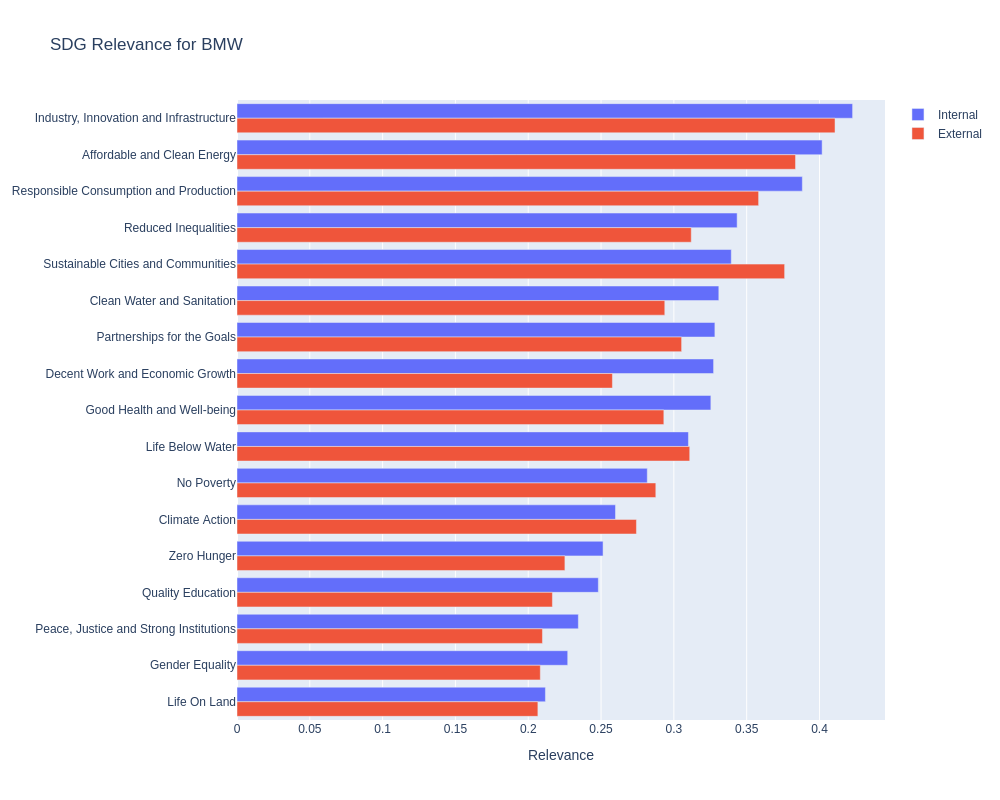

In [18]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig, format='png', height = 800, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

In [19]:
# Internally most important SDG
# Get the top 3 rows based on the 'internal' column
top_3_internal = company_df.nlargest(3, 'internal')

# Print the name and internal value for each row
print(f"Top 3 internally most important SDG's for {company}:")
for index, row in top_3_internal.iterrows():
    print(f"Name: {row['name']}, Internal Value: {round(row['internal'], 3)}")

# Externally most important SDG
# Get the top 3 rows based on the 'external' column
print('\n' + f"Top 3 externally most important SDG's for {company}:")
top_3_external = company_df.nlargest(3, 'external')

# Print the name and external value for each row
for index, row in top_3_external.iterrows():
    print(f"Name: {row['name']}, Internal Value: {round(row['external'], 3)}")

# Overall most important SDG
# Get the top 3 rows based on the 'overall' column
print('\n' + f"Top 3 overall most important SDG's for {company}:")
top_3_overall = company_df.nlargest(3, 'overall')

# Print the name and overall value for each row
for index, row in top_3_overall.iterrows():
    print(f"Name: {row['name']}, Internal Value: {round(row['overall'], 3)}")

# SDG with largest relevance GAP between internal and external
# Calculate the absolute difference between internal and external values
company_df['abs_diff'] = company_df['internal'].sub(company_df['external']).abs()

# Get the top 3 rows based on the 'abs_diff' column
top_3_diff = company_df.nlargest(3, 'abs_diff')

# Print the name and absolute difference value for each row
print('\n' + f"Top 3 absolute differences between internal and external for {company}:")
for index, row in top_3_diff.iterrows():
    print(f"Name: {row['name']}, Absolute Difference: {round(row['abs_diff'], 3)}, Effective Difference: {round(row['diff'], 3)}")

Top 3 internally most important SDG's for BMW:
Name: Industry, Innovation and Infrastructure, Internal Value: 0.423
Name: Affordable and Clean Energy, Internal Value: 0.402
Name: Responsible Consumption and Production, Internal Value: 0.388

Top 3 externally most important SDG's for BMW:
Name: Industry, Innovation and Infrastructure, Internal Value: 0.411
Name: Affordable and Clean Energy, Internal Value: 0.384
Name: Sustainable Cities and Communities, Internal Value: 0.376

Top 3 overall most important SDG's for BMW:
Name: Industry, Innovation and Infrastructure, Internal Value: 0.411
Name: Affordable and Clean Energy, Internal Value: 0.384
Name: Sustainable Cities and Communities, Internal Value: 0.376

Top 3 absolute differences between internal and external for BMW:
Name: Decent Work and Economic Growth, Absolute Difference: 0.069, Effective Difference: 0.069
Name: Clean Water and Sanitation, Absolute Difference: 0.037, Effective Difference: 0.037
Name: Sustainable Cities and Commu

We can extract the following key findings from the analysis for BMW:
- The SDGs that are most relevant internally, externally and thus also overall are 'Industry, Innovation and Infrastructure', 'Affordable and Clean Energy', and 'Responsible Consumption and Production'.
- We consider it positive that the three internally most relevant SDGs correspond to the three externally most relevant SDGs.
- In our view, the three most relevant SDGs are consistent for an automotive group like BMW.
- The biggest discrepancies are in the SDGs 'Decent Work and Economic Growth', 'Clean Water and Sanitation', and 'Sustainable Cities and Communities'. In the case of the first two, the internal relevance is higher than the external relevance (effectively positive difference), and in the case of the last, the external relevance is higher than the internal relevance (effectively negative difference).

#### 3.2.2 Most Relevant SDGs - Aggregated Results

We now aggregate the results on company level in heatmaps.

In [20]:
# Create company embeddings
company_embeddings = []
for company in companies:
    company_indices = esg_documents_df[esg_documents_df.company == company].index
    company_embedding = np.mean(company_text_embeddings[company_indices], axis=0)
    company_embeddings.append(company_embedding)

# Create company records
company_records = []
for company_embedding in company_embeddings:
    company_record = []
    for sdg_embedding in sdg_embeddings:
        company_record.append(cosine_similarity(company_embedding, sdg_embedding))
    company_records.append(company_record)

# Create heatmap array
heatmap_array = np.array(company_records)
heatmap_array.shape

(37, 17)

In [21]:
# sort heatmap array by sum of row values descending
heatmap_array_sorted = heatmap_array[np.argsort(heatmap_array.sum(axis=1))]

# creat sorted list of company names according to heatmap_array_sorted
companies_sorted = [companies[i] for i in np.argsort(heatmap_array.sum(axis=1))]

# display heatmap_array_sorted as fig2
fig2 = go.Figure(data=go.Heatmap( z=heatmap_array_sorted, x=sdg_df["name"].tolist(), y=[company + " " for company in companies_sorted], colorscale='Viridis'))
fig2.update_layout(height=1000)
fig2.update_layout(title_text='Relevance of SDGs for DAX Companies - Company Level - Row Sorted', title_x=0.5, title_font=dict(size=30))
fig2.show()

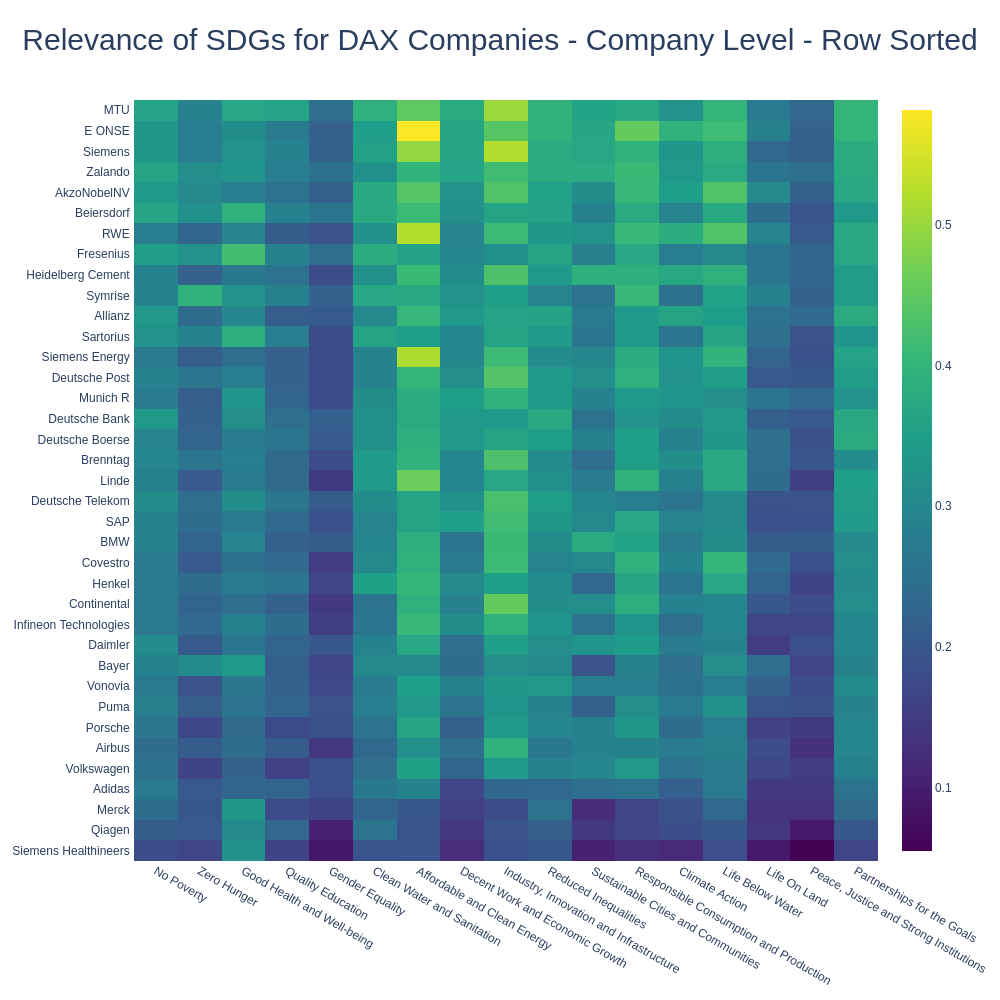

In [22]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig2, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

The plot above show the overall importance of SDG goals for DAX companies, using the mean of the SDG embeddings over all documents. SDG alignment is defined as the similarity between the company-related texts and the SDG descriptions. In addition, the plot is sorted by the sum of each row. The heatmap shows that the companies MTU, E ONSE and Siemens have the highest overall sum of SDG alignment while Siemens Healthineers, Qiagen and Merck have lowest. The overall highest relevance of a SDG goal for one company is 'Affordable and Clean Energy' for E ONSE (0.58) which makes absolutely sense since E ONSE is an operator in energy networks and energy infrastructure and a energy provider as well.

In [23]:
# sort heatmap array by sum of column values descending
heatmap_array_sorted_columns = heatmap_array[:, np.argsort(heatmap_array.sum(axis=0))]

# creat sorted list of sdg names according to heatmap_array_sorted_columns
sdg_names_sorted = [sdg_df["name"].tolist()[i] for i in np.argsort(heatmap_array.sum(axis=0))]

# display heatmap_array_sorted_columns as fig3
fig3 = go.Figure(data=go.Heatmap( z=heatmap_array_sorted_columns, x=sdg_names_sorted, y=[company + " " for company in companies], colorscale='Viridis'))
fig3.update_layout(height=1000)
fig3.update_layout(title_text='Relevance of SDGs for DAX Companies - Company Level - Column Sorted', title_x=0.5, title_font=dict(size=30))
fig3.show()

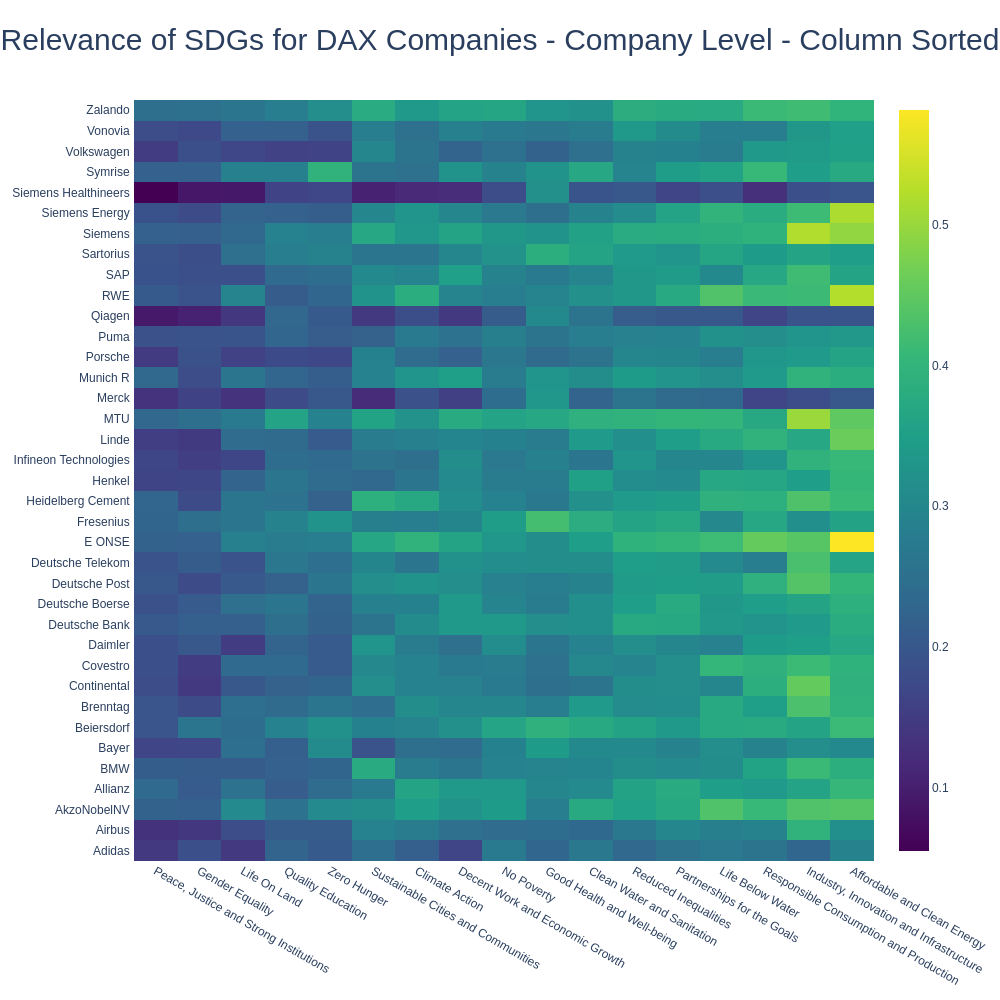

In [24]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig3, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

When sorting the overall SDG alligment by the sum of each column, the most important SDGs for DAX comapnies can be identified on the right side of the plot. The three most important SDGs are 'Affordable and Clean Energy', 'Industry, Innovation and Infrastructure' and 'Responsible Consumption and Production'. 

In [25]:
# Create a heatmap of company_sdg_relevance_df['sdg_relevance'] using 'diff' as values (internal - external)
diff_values_per_row = [
    [item['diff'] for item in sublist]
    for sublist in company_sdg_relevance_df['sdg_relevance']
]

heatmap_array_diff = np.array(diff_values_per_row)

# Calculate the row sums
row_sums = heatmap_array_diff.sum(axis=1)

# Sort heatmap_array_diff and row_sums in descending order
sorted_indices = np.argsort(row_sums)  #[::-1]
heatmap_array_diff_sorted = heatmap_array_diff[sorted_indices]
row_sums_sorted = row_sums[sorted_indices]

# Create a sorted list of company names according to heatmap_array_diff_sorted
companies_sorted = [companies[i] for i in sorted_indices]

# Display heatmap_array_diff_sorted as fig4
fig4 = go.Figure(data=go.Heatmap(
    z=heatmap_array_diff_sorted,
    x=sdg_df["name"].tolist(),
    y=[company + " " for company in companies_sorted],
    colorscale='RdYlGn_r',  # Use 'RdYlGn_r' for the inverted colorscale
    zmid=0  # Set the midpoint at 0
))
fig4.update_layout(height=1000)
fig4.update_layout(title_text='Differences of Internal minus External SDG Values - Company Level', title_x=0.5, title_font=dict(size=30))
fig4.show()

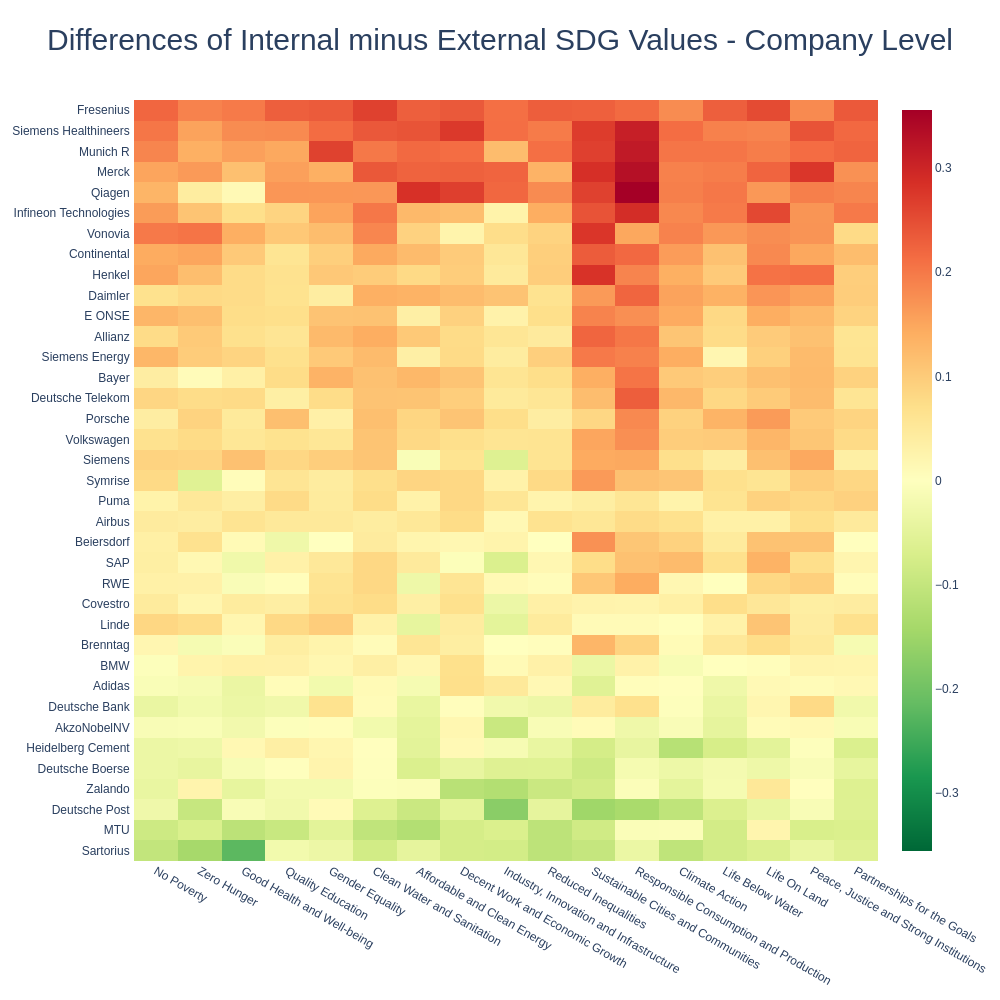

In [26]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig4, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

Comparing internal and external SDG embedding based on the difference of internal minus external SDG score reveals interesting patterns. The darker an SDG is colored in red, the more relevant it is according to the company, but less relevant according to external sources. Yellow colored boxes indicate more consistent internal and external scores. At the bottom of the chart, in increasing green color, are the companies for which the external sources show greater alignment with the SDG descriptions than the internal documents.

### 3.2 Most Relevant SDGs for DAX Companies - Sector Level

On sector level, we do not display detailed results for one sector as above for one company. We start straight with the heatmaps since they contain all relevant information. In contrast to the analysis on company level we do not display the column sorted heatmap again because it basically provides the same information as on company level.

In [27]:
# Create sector embeddings
sector_embeddings = []
for sector in sectors:
    sector_indices = esg_documents_df[esg_documents_df.sector == sector].index
    sector_embedding = np.mean(company_text_embeddings[sector_indices], axis=0)
    sector_embeddings.append(sector_embedding)

# Create sector records
sector_records = []
for sector_embedding in sector_embeddings:
    sector_record = []
    for sdg_embedding in sdg_embeddings:
        sector_record.append(cosine_similarity(sector_embedding, sdg_embedding))
    sector_records.append(sector_record)

# Create heatmap array
heatmap_array = np.array(sector_records)
heatmap_array.shape

(10, 17)

In [28]:
# sort heatmap array by sum of row values descending
heatmap_array_sorted = heatmap_array[np.argsort(heatmap_array.sum(axis=1))]

# creat sorted list of sector names according to heatmap_array_sorted
sectors_sorted = [sectors[i] for i in np.argsort(heatmap_array.sum(axis=1))]

# display heatmap_array_sorted as fig5
fig5 = go.Figure(data=go.Heatmap( z=heatmap_array_sorted, x=sdg_df["name"].tolist(), y=[sector + " " for sector in sectors_sorted], colorscale='Viridis'))
fig5.update_layout(height=1000)
fig5.update_layout(title_text='Relevance of SDGs for DAX Companies - Sector Level - Row Sorted', title_x=0.5, title_font=dict(size=30))
fig5.show()

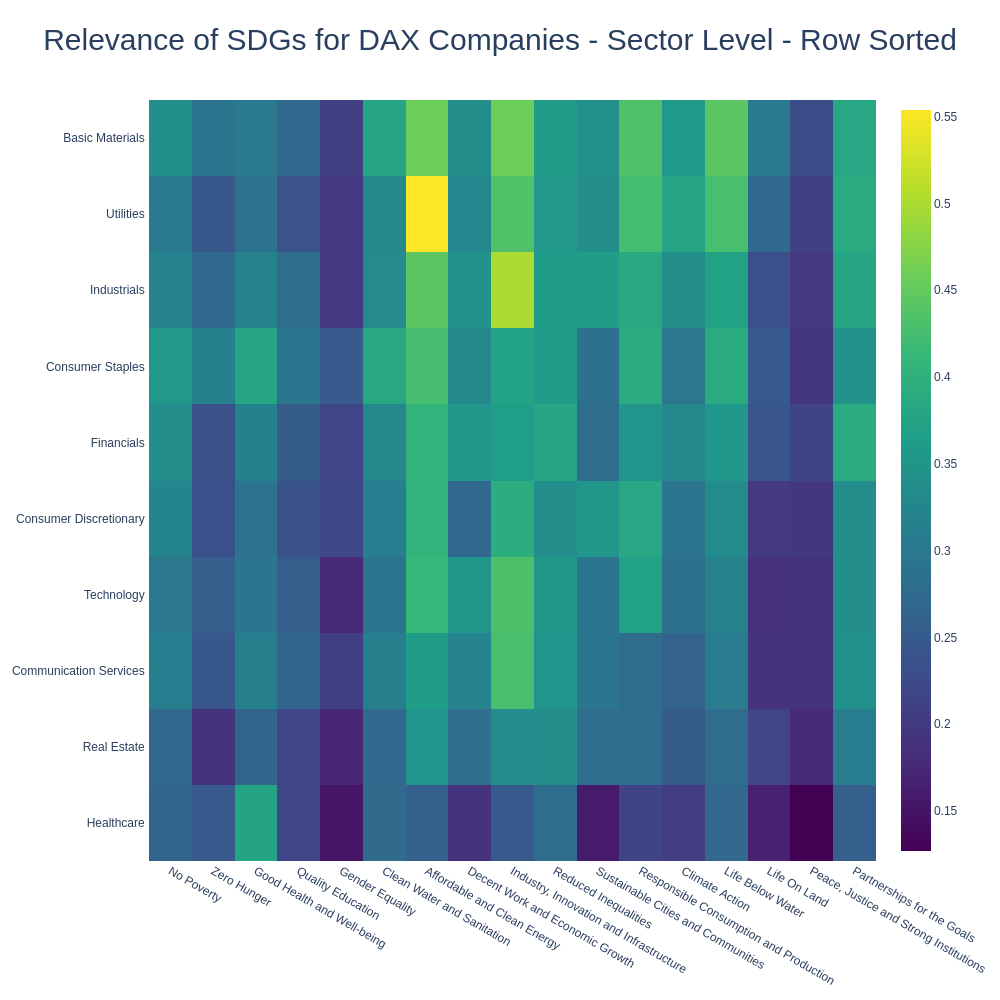

In [29]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig5, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

The graphic above shows the importance of the various SDG targets per sector. The stronger the green or even yellow portion of a box's color, the more relevant an SDG is. For example, the goal previously identified as the most important SDG, 'Affordable and Clean Energy', appears to be particularly important for the utilities sector, which makes perfect sense. Overall, the SDG targets for the basic materials, utilities, and industrial sectors appear to be most relevant. On the other hand, SDG targets for the healthcare and real estate sectors seem to be of little relevance. Nevertheless, there are some SDGs that are also relevant for these sectors (e.g., 'Good Health and Well-being' for the healthcare sector or 'Affordable and Clean Energy' for the real estate sector).

In [30]:
# Differences per sector
# Extract the mean values per sector considering the 'sector' column in company_sdg_relevance_df and the unique sectors in sectors
mean_values_per_sector = [np.mean(np.array(diff_values_per_row)[company_sdg_relevance_df['sector'] == sector], axis=0) for sector in sectors]

# sort mean_values_per_sector by sum of row values descending
mean_values_per_sector_sorted = np.array(mean_values_per_sector)[np.argsort(np.array(mean_values_per_sector).sum(axis=1))]  #[::-1]

# creat sorted list of sector names according to mean_values_per_sector_sorted
sectors_sorted = [sectors[i] for i in np.argsort(np.array(mean_values_per_sector).sum(axis=1))]  #[::-1]

# create a heatmap with mean_values_per_sector as values and industries as y-axis, x-axis is sdg_df["name"].tolist()
fig7 = go.Figure(data=go.Heatmap( z=mean_values_per_sector_sorted, x=sdg_df["name"].tolist(), y=[sector + " " for sector in sectors_sorted], colorscale='RdYlGn_r', zmid=0))
fig7.update_layout(height=1000)
fig7.update_layout(title_text='Differences of Internal minus External SDG Values - Sector Level', title_x=0.5, title_font=dict(size=30))
fig7.show()


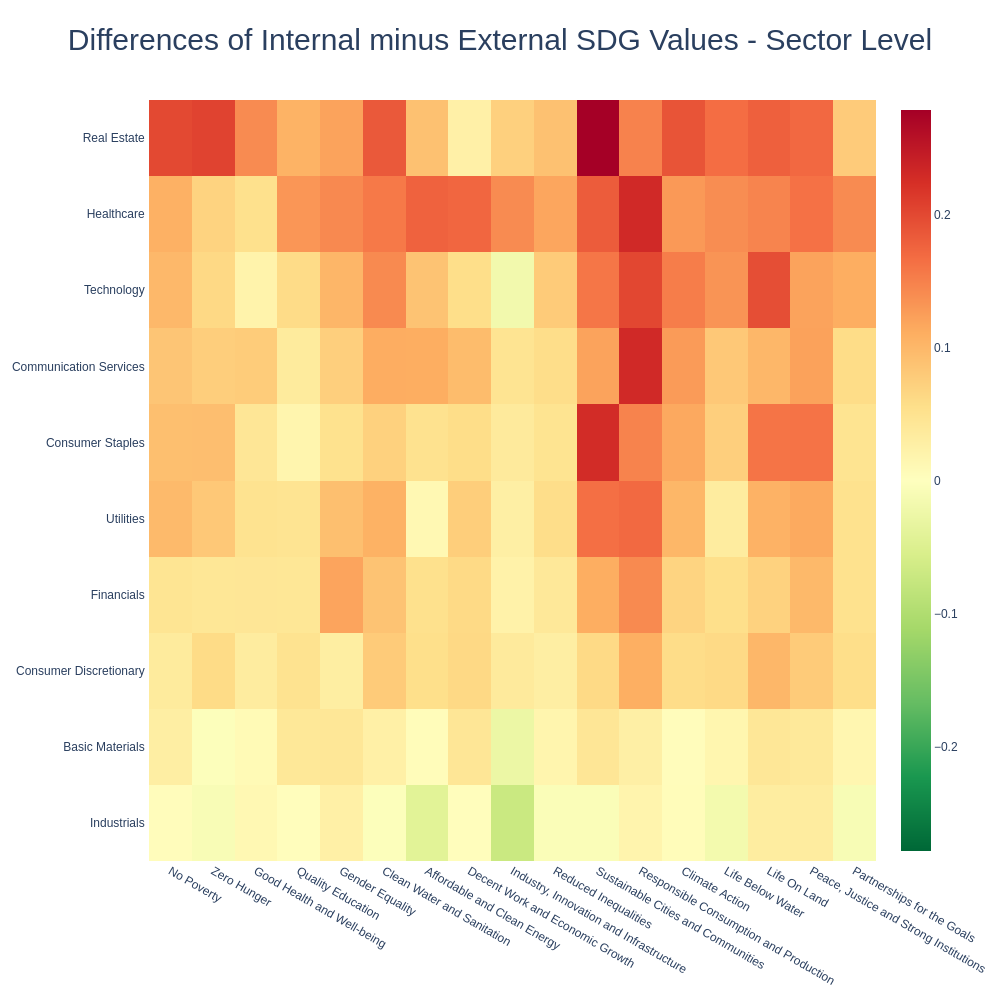

In [31]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig7, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

Only a few green fields, but many red ones are visible in the graph. This means that at sector level, the SDG goals are in most cases more relevant internally than externally.

### 3.3 Most Relevant SDGs for DAX Companies - Industry Level

On industry level, we do not display detailed results for one industry as above for one company. We start straight with the heatmaps since the contain all relevant information. In contrast to the analysis on company level we do not display the column sorted heatmap again because it basically provides the same information as on company level.

In [32]:
# Create industry embeddings
industry_embeddings = []
for industry in industries:
    industry_indices = esg_documents_df[esg_documents_df.industry == industry].index
    industry_embedding = np.mean(company_text_embeddings[industry_indices], axis=0)
    industry_embeddings.append(industry_embedding)

# Create industry records
industry_records = []
for industry_embedding in industry_embeddings:
    industry_record = []
    for sdg_embedding in sdg_embeddings:
        industry_record.append(cosine_similarity(industry_embedding, sdg_embedding))
    industry_records.append(industry_record)

# Create heatmap array
heatmap_array = np.array(industry_records)
heatmap_array.shape

(26, 17)

In [33]:
# sort heatmap array by sum of row values descending
heatmap_array_sorted = heatmap_array[np.argsort(heatmap_array.sum(axis=1))]

# creat sorted list of sector names according to heatmap_array_sorted
industries_sorted = [industries[i] for i in np.argsort(heatmap_array.sum(axis=1))]

# display heatmap_array_sorted as fig5
fig8 = go.Figure(data=go.Heatmap( z=heatmap_array_sorted, x=sdg_df["name"].tolist(), y=[industry + " " for industry in industries_sorted], colorscale='Viridis'))
fig8.update_layout(height=1000)
fig8.update_layout(title_text='Relevance of SDGs for DAX Companies - Industry Level - Row Sorted', title_x=0.5, title_font=dict(size=30))
fig8.show()

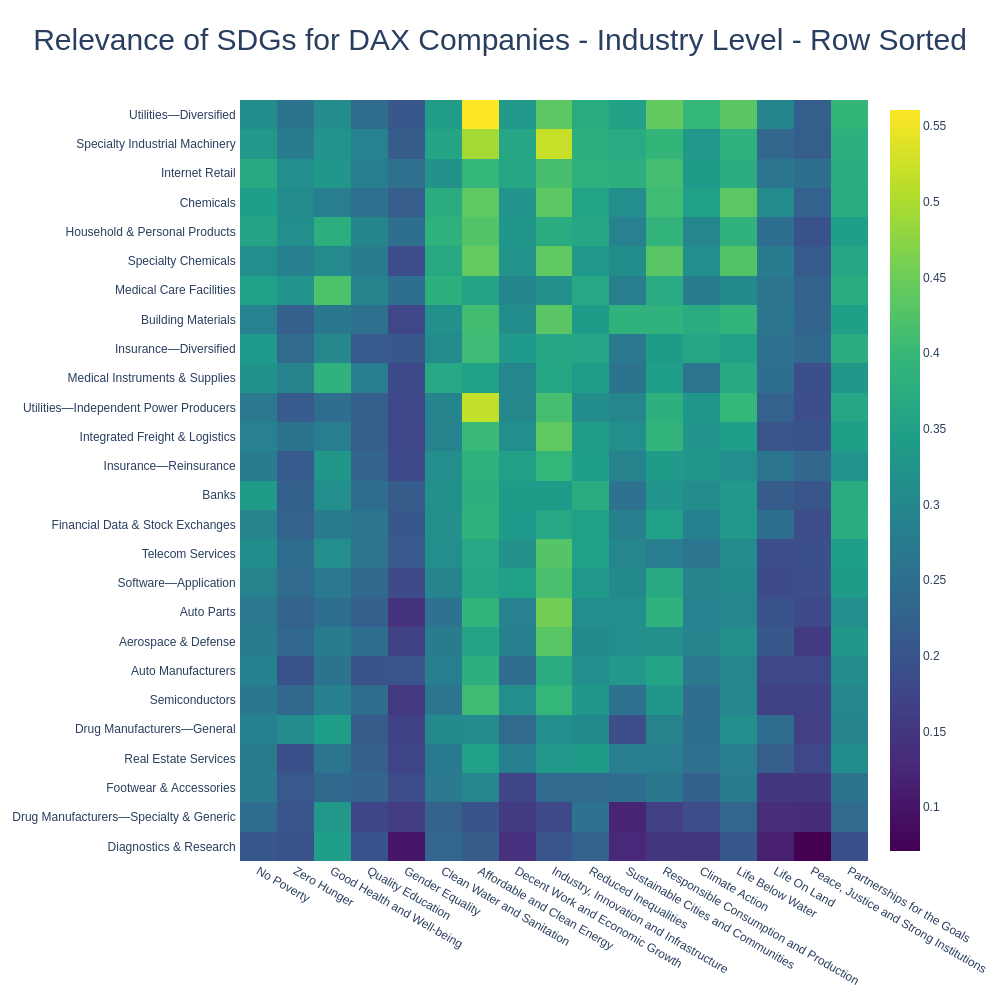

In [34]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig8, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

The graphic above shows the importance of the various SDG targets per industry. The stronger the green or even yellow portion of a box's color, the more relevant an SDG is. For example, the goal previously identified as the most important SDG, 'Affordable and Clean Energy', appears to be particularly important for the utilities - diversified industry, which makes perfect sense. Overall, the SDG targets for the utilities - diversified, speciality industrial machinery, and internet retail industries appear to be most relevant. On the other hand, SDG targets for the diagnostics & research and drug manufacturers industries seem to be of little relevance.

In [35]:
# Differences per industry
# Extract the mean values per industry considering the 'industry' column in company_sdg_relevance_df and the unique industries in industries
mean_values_per_industry = [ np.mean(np.array(diff_values_per_row)[company_sdg_relevance_df['industry'] == industry], axis=0) for industry in industries ]

# sort mean_values_per_industry by sum of row values descending
mean_values_per_industry_sorted = np.array(mean_values_per_industry)[np.argsort(np.array(mean_values_per_industry).sum(axis=1))]  #[::-1]
# creat sorted list of industry names according to mean_values_per_industry_sorted
industries_sorted = [industries[i] for i in np.argsort(np.array(mean_values_per_industry).sum(axis=1))]  #[::-1]

# create a heatmap with mean_values_per_industry as values and industries as y-axis, x-axis is sdg_df["name"].tolist()
fig5 = go.Figure(data=go.Heatmap( z=mean_values_per_industry_sorted, x=sdg_df["name"].tolist(), y=[industry + " " for industry in industries_sorted], colorscale='RdYlGn_r', zmid=0))
fig5.update_layout(height=1000)
fig5.update_layout(title_text='Differences of Internal minus External SDG Values  - Industry Level', title_x=0.5, title_font=dict(size=30))
fig5.show()


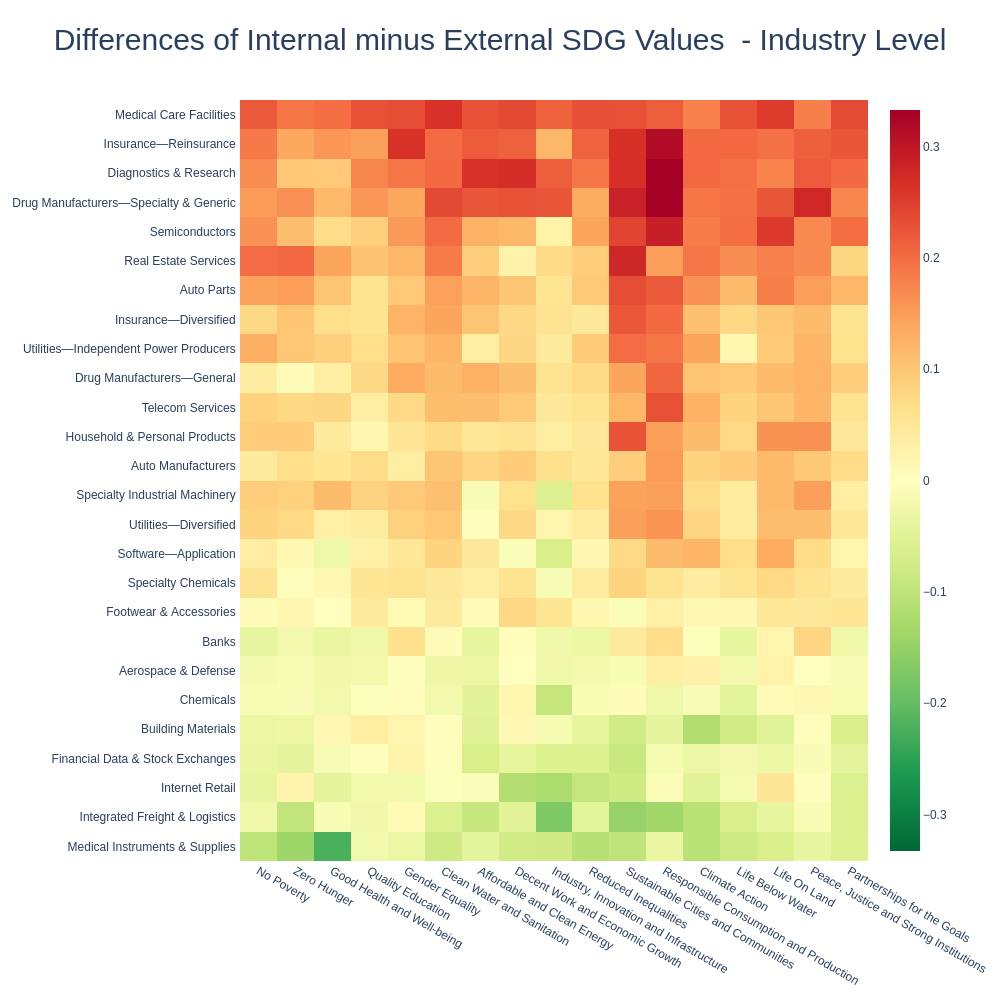

In [36]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig5, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

When analyzing the differences the iternal and external SDG scores per industry, additional patterns can be observed. As the plot above is sorted by the sum of each row, the industries at the bottom of the plot show the largest negative discrepancy, colored in intensifying red. A negative discrepancy is assumed if the internal values are higher than the externales values. Especially the medical instrument & supplies and integrated freight & logistics industries show the largest negative inconsistency between internal and external company-related texts in regard to the SDG descriptions. 